Importing required packages

In [7]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import os
import statsmodels.api as sm
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns



Categorising menu items

In [8]:
# Path to data folder
data_dir = r"C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\data"

# List of CSV files and their corresponding chain names
chain_files = {
    "chick_fil_a_nutrition.csv": "Chick-fil-A",
    "burger_king_nutrition.csv": "Burger King",
    "kfc_nutrition.csv": "KFC",
    "subway_nutrition.csv": "Subway",
    "mcdonalds_nutrition.csv": "McDonald's" 
}

# Function to categorise items based on their name
def categorise_item(item):
    item = item.lower()
    if 'chicken' in item:
        return 'Chicken'
    elif 'burger' in item:
        return 'Burger'
    elif 'fish' in item:
        return 'Fish'
    elif 'salad' in item:
        return 'Salad'
    elif 'wrap' in item:
        return 'Wrap'
    elif 'sub' in item or 'sandwich' in item:
        return 'Sandwich'
    elif 'side' in item or 'fries' in item:
        return 'Side'
    elif 'drink' in item or 'beverage' in item:
        return 'Drink'
    else:
        return 'Other'

# Combine data
combined_df = pd.DataFrame()

for file_name, chain_name in chain_files.items():
    path = os.path.join(data_dir, file_name)
    if os.path.exists(path):
        print(f"Loading: {file_name}")
        df = pd.read_csv(path)

        # Add chain name
        df["Chain"] = chain_name

        # Ensure 'Item' column exists
        if "Item" in df.columns:
            df["category"] = df["Item"].apply(categorise_item)
        else:
            print(f"Warning: 'Item' column not found in {file_name}")
            df["category"] = "Unknown"

        combined_df = pd.concat([combined_df, df], ignore_index=True)
    else:
        print(f"File not found: {path}")

# Save master CSV
output_path = os.path.join(data_dir, "master_nutrition_data.csv")
combined_df.to_csv(output_path, index=False)
print(f"\nMaster dataset saved to: {output_path}")


Loading: chick_fil_a_nutrition.csv
Loading: burger_king_nutrition.csv
Loading: kfc_nutrition.csv
Loading: subway_nutrition.csv
Loading: mcdonalds_nutrition.csv

Master dataset saved to: C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\data\master_nutrition_data.csv


Checking what the merged dataset looks like

In [9]:
# Load master dataset
merged_df = pd.read_csv(r"C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\data\master_nutrition_data.csv")

# Clean up column names
merged_df.columns = merged_df.columns.str.strip()

# Convert relevant columns to numeric
numeric_columns = [
    'Calories', 'Total Fat (g)', 'Saturated Fat (g)', 'Trans Fat (g)',
    'Cholesterol (mg)', 'Sodium (mg)', 'Total Carbohydrates (g)',
    'Dietary Fiber (g)', 'Sugars (g)', 'Protein (g)'
]

for col in numeric_columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')  # convert and handle non-numeric values

# Check what the data looks like now
print(merged_df.head())
print("\nNull values per column:")
print(merged_df[numeric_columns].isnull().sum())


                                 Item  Calories  Total Fat (g)  \
0   4 Count Chick-Fil-A Chick-N-Minis     360.0           13.0   
1            4 Count Mini Yeast Rolls     240.0            8.0   
2  10 Count Chick-Fil-A Chick-N-Minis     910.0           34.0   
3         Bacon, Egg & Cheese Biscuit     420.0           23.0   
4          Bacon, Egg & Cheese Muffin     300.0           13.0   

   Saturated Fat (g)  Trans Fat (g)  Cholesterol (mg)  Sodium (mg)  \
0                4.0            0.0              60.0         1060   
1                2.5            0.0              20.0          450   
2               10.0            0.0             150.0         2640   
3               11.0            0.0             180.0         1220   
4                6.0            0.0             180.0          780   

   Total Carbohydrates (g)  Dietary Fiber (g)  Sugars (g)  Protein (g)  \
0                       41                2.0         8.0           20   
1                       36        

Dropping rows missing key nutrients for analysis aswell as making a protein per 100 calories column

In [10]:
# Drop rows with missing key nutrients
merged_df.dropna(subset=['Calories', 'Protein (g)'], inplace=True)

# Add a new metric, protein per 100 Calories
merged_df['Protein per 100 Cal'] = (merged_df['Protein (g)'] / merged_df['Calories']) * 100

merged_df['Chain'] = merged_df['Chain'].str.strip().str.title()

# Preview
merged_df.head()


,Item,Calories,Total Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carbohydrates (g),Dietary Fiber (g),Sugars (g),Protein (g),Chain,category,Protein per 100 Cal
0,4 Count Chick-Fil-A Chick-N-Minis,360.0,13.0,4.0,0.0,60.0,1060,41,2.0,8.0,20,Chick-Fil-A,Other,5.555556
1,4 Count Mini Yeast Rolls,240.0,8.0,2.5,0.0,20.0,450,36,2.0,7.0,6,Chick-Fil-A,Other,2.500000
2,10 Count Chick-Fil-A Chick-N-Minis,910.0,34.0,10.0,0.0,150.0,2640,103,6.0,19.0,49,Chick-Fil-A,Other,5.384615
3,"Bacon, Egg & Cheese Biscuit",420.0,23.0,11.0,0.0,180.0,1220,38,2.0,4.0,15,Chick-Fil-A,Other,3.571429
4,"Bacon, Egg & Cheese Muffin",300.0,13.0,6.0,0.0,180.0,780,28,1.0,2.0,16,Chick-Fil-A,Other,5.333333


Further data cleaning

In [11]:
# Clean the 'Chain' column to ensure uniformity
merged_df['Chain'] = merged_df['Chain'].str.strip().str.title()

# Save the cleaned dataset to a new CSV file
output_path = r"C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\data\cleaned_nutrition_data.csv"
merged_df.to_csv(output_path, index=False)

print(f"\nCleaned data saved to: {output_path}")



Cleaned data saved to: C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\data\cleaned_nutrition_data.csv


Finding most common words to categorise

In [12]:
# Clean column names just in case
merged_df.columns = merged_df.columns.str.strip()

# Combine all item names into one string, lowercase and split into words
all_items = " ".join(merged_df['Item'].dropna().astype(str)).lower()

# Remove punctuation and split into words
words = re.findall(r'\b\w+\b', all_items)

# Remove common stop words
stopwords = {'with', 'and', 'or', 'a', 'the', 'of', 'on', 'to', 'for', 'in', 'at', 'from'}
filtered_words = [word for word in words if word not in stopwords]

# Count frequency
word_counts = Counter(filtered_words)

# Show the 30 most common words
most_common = word_counts.most_common(30)
for word, count in most_common:
    print(f"{word}: {count}")


chicken: 123
small: 105
fl: 98
oz: 98
large: 95
chick: 93
medium: 90
cheese: 71
salad: 71
tea: 71
fil: 68
lemonade: 65
1: 61
iced: 61
wrap: 60
grilled: 57
6: 57
spicy: 52
sandwich: 51
tray: 48
hash: 47
diet: 47
bowl: 45
2: 44
nuggets: 42
bacon: 41
per: 41
egg: 39
sweet: 34
chocolate: 32


Creating categories for different types of food to aid analysis

In [13]:
# Define category keywords
category_keywords = {
    'Chicken': ['chicken', 'chick', 'nuggets', 'fil', 'grilled', 'spicy'],
    'Salad': ['salad'],
    'Wrap': ['wrap'],
    'Burger': ['burger'],
    'Beverage': ['tea', 'lemonade', 'iced', 'diet', 'sweet', 'drink', 'juice', 'soda'],
    'Dessert': ['chocolate', 'cookie', 'ice cream', 'dessert'],
    'Breakfast': ['egg', 'hash', 'bacon'],
    'Side': ['sauce', 'tray', 'side', 'fries'],
    'Combo': ['bowl', '1', '2', '6', '12']  # optional utility grouping
}

# Function to assign categories
def categorise_item_multi(name):
    name = name.lower()
    matched = set()
    for category, keywords in category_keywords.items():
        if any(keyword in name for keyword in keywords):
            matched.add(category)
    if not matched:
        return ['Other']
    return list(matched)

# Apply multi-label categorisation
merged_df['Category'] = merged_df['Item'].apply(categorise_item_multi)

# Preview results
merged_df


,Item,Calories,Total Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carbohydrates (g),Dietary Fiber (g),Sugars (g),Protein (g),Chain,category,Protein per 100 Cal,Category
0,4 Count Chick-Fil-A Chick-N-Minis,360.0,13.0,4.0,0.0,60.0,1060,41,2.0,8.0,20,Chick-Fil-A,Other,5.555556,[Chicken]
1,4 Count Mini Yeast Rolls,240.0,8.0,2.5,0.0,20.0,450,36,2.0,7.0,6,Chick-Fil-A,Other,2.500000,[Other]
2,10 Count Chick-Fil-A Chick-N-Minis,910.0,34.0,10.0,0.0,150.0,2640,103,6.0,19.0,49,Chick-Fil-A,Other,5.384615,"[Chicken, Combo]"
3,"Bacon, Egg & Cheese Biscuit",420.0,23.0,11.0,0.0,180.0,1220,38,2.0,4.0,15,Chick-Fil-A,Other,3.571429,[Breakfast]
4,"Bacon, Egg & Cheese Muffin",300.0,13.0,6.0,0.0,180.0,780,28,1.0,2.0,16,Chick-Fil-A,Other,5.333333,[Breakfast]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,"Sweet Tea, Small",100.0,0.0,0.0,0.0,0.0,15,26,0.0,24.0,0,Mcdonald'S,Other,0.000000,[Beverage]
1173,"Unsweetened Iced Tea, Extra Small",0.0,0.0,0.0,0.0,0.0,10,0,0.0,0.0,1,Mcdonald'S,Other,inf,[Beverage]
1174,"Unsweetened Iced Tea, Large",0.0,0.0,0.0,0.0,0.0,20,0,0.0,0.0,1,Mcdonald'S,Other,inf,[Beverage]
1175,"Unsweetened Iced Tea, Medium",0.0,0.0,0.0,0.0,0.0,15,0,0.0,0.0,1,Mcdonald'S,Other,inf,[Beverage]


Categorising into small medium and large

In [14]:
# Define allowed size labels
valid_sizes = ['small', 'medium', 'large']

# Function to extract size
def extract_size(name):
    name = name.lower()
    for size in valid_sizes:
        if size in name:
            return size.capitalize()
    return 'N/A'

# Apply function to create Size column
merged_df['Size'] = merged_df['Item'].apply(extract_size)

# Preview
merged_df


,Item,Calories,Total Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carbohydrates (g),Dietary Fiber (g),Sugars (g),Protein (g),Chain,category,Protein per 100 Cal,Category,Size
0,4 Count Chick-Fil-A Chick-N-Minis,360.0,13.0,4.0,0.0,60.0,1060,41,2.0,8.0,20,Chick-Fil-A,Other,5.555556,[Chicken],N/A
1,4 Count Mini Yeast Rolls,240.0,8.0,2.5,0.0,20.0,450,36,2.0,7.0,6,Chick-Fil-A,Other,2.500000,[Other],N/A
2,10 Count Chick-Fil-A Chick-N-Minis,910.0,34.0,10.0,0.0,150.0,2640,103,6.0,19.0,49,Chick-Fil-A,Other,5.384615,"[Chicken, Combo]",N/A
3,"Bacon, Egg & Cheese Biscuit",420.0,23.0,11.0,0.0,180.0,1220,38,2.0,4.0,15,Chick-Fil-A,Other,3.571429,[Breakfast],N/A
4,"Bacon, Egg & Cheese Muffin",300.0,13.0,6.0,0.0,180.0,780,28,1.0,2.0,16,Chick-Fil-A,Other,5.333333,[Breakfast],N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,"Sweet Tea, Small",100.0,0.0,0.0,0.0,0.0,15,26,0.0,24.0,0,Mcdonald'S,Other,0.000000,[Beverage],Small
1173,"Unsweetened Iced Tea, Extra Small",0.0,0.0,0.0,0.0,0.0,10,0,0.0,0.0,1,Mcdonald'S,Other,inf,[Beverage],Small
1174,"Unsweetened Iced Tea, Large",0.0,0.0,0.0,0.0,0.0,20,0,0.0,0.0,1,Mcdonald'S,Other,inf,[Beverage],Large
1175,"Unsweetened Iced Tea, Medium",0.0,0.0,0.0,0.0,0.0,15,0,0.0,0.0,1,Mcdonald'S,Other,inf,[Beverage],Medium


In [15]:
# Define your output directory
output_dir = r"C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\data"

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the file path for your complete dataset
complete_data_path = os.path.join(output_dir, 'complete_fast_food_data.csv')

# Save the merged_df to this file path
merged_df.to_csv(complete_data_path, index=False)

print(f" Merged dataset saved as '{complete_data_path}'")

 Merged dataset saved as 'C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\data\complete_fast_food_data.csv'


Showing the correlation between calorie count and quantity of macronutrients

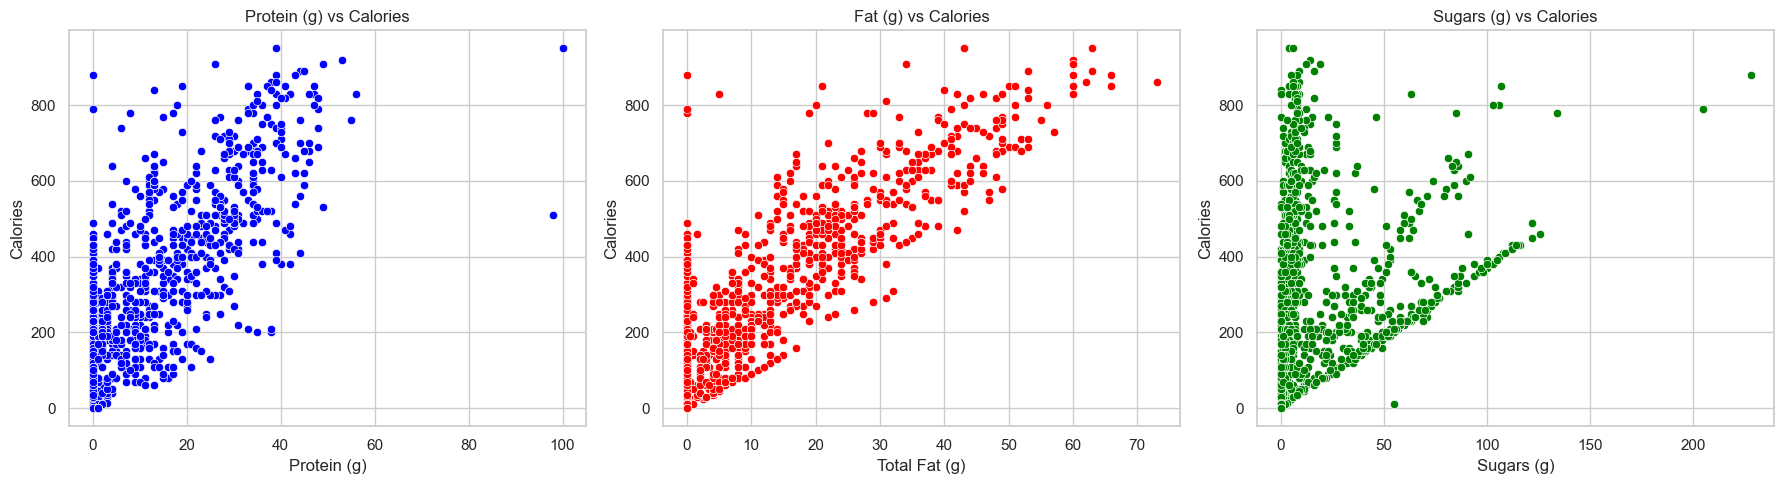

Correlation between Nutrients and Calories:
               Protein (g)  Total Fat (g)  Sugars (g)  Calories
Protein (g)       1.000000       0.755015   -0.280646  0.750939
Total Fat (g)     0.755015       1.000000   -0.257563  0.847771
Sugars (g)       -0.280646      -0.257563    1.000000  0.174628
Calories          0.750939       0.847771    0.174628  1.000000


In [16]:
# Handle any non-numeric values by converting them into NaN
merged_df['Protein (g)'] = pd.to_numeric(merged_df['Protein (g)'], errors='coerce')
merged_df['Total Fat (g)'] = pd.to_numeric(merged_df['Total Fat (g)'], errors='coerce')
merged_df['Sugars (g)'] = pd.to_numeric(merged_df['Sugars (g)'], errors='coerce')
merged_df['Calories'] = pd.to_numeric(merged_df['Calories'], errors='coerce')

# Now visualise how Protein, Fat and Sugar relate to calories through scatter plots
sns.set(style="whitegrid")

# Create a figure with 3 subplots, one for each comparison: Protein vs Calories, Fat vs Calories, and Sugar vs Calories
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot for Protein vs Calories
sns.scatterplot(x='Protein (g)', y='Calories', data=merged_df, ax=axes[0], color='blue')
axes[0].set_title("Protein (g) vs Calories")
axes[0].set_xlabel("Protein (g)")
axes[0].set_ylabel("Calories")

# Scatter plot for Fat vs Calories
sns.scatterplot(x='Total Fat (g)', y='Calories', data=merged_df, ax=axes[1], color='red')
axes[1].set_title("Fat (g) vs Calories")
axes[1].set_xlabel("Total Fat (g)")
axes[1].set_ylabel("Calories")

# Scatter plot for Sugar vs Calories
sns.scatterplot(x='Sugars (g)', y='Calories', data=merged_df, ax=axes[2], color='green')
axes[2].set_title("Sugars (g) vs Calories")
axes[2].set_xlabel("Sugars (g)")
axes[2].set_ylabel("Calories")

# Adjust the layout so that the plots don't overlap
plt.tight_layout()
plt.show()

# Calculate and display the correlation between Protein, Fat, Sugar and Calories
correlation = merged_df[['Protein (g)', 'Total Fat (g)', 'Sugars (g)', 'Calories']].corr()
print("Correlation between Nutrients and Calories:")
print(correlation)


Calculating outliers that are physically impossible

Number of significant outliers detected: 21
      Protein (g)  Total Fat (g)  Sugars (g)  Calories  \
162             0            0.0        53.0     190.0   
183             0            0.0        86.0     310.0   
193             0            0.0        53.0     190.0   
436             0            0.0        47.0     170.0   
503             0            0.0        55.0      10.0   
505             0            0.0        71.0     240.0   
506             0            0.0        49.0     160.0   
507             0            0.0        35.0     120.0   
508             0            0.0        25.0      90.0   
677             0            0.0        36.0     130.0   
696             0            0.0        39.0     140.0   
706             0            0.0        69.0     250.0   
895             1            3.0         1.0      30.0   
926             3            5.0         0.0      50.0   
1047           11           26.0        84.0     350.0   
1162            0           

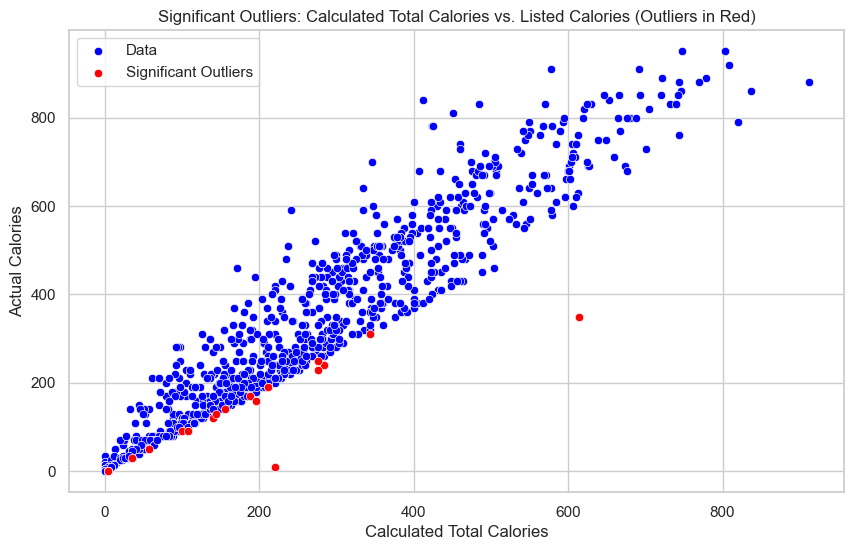

In [36]:
# Calculate the expected calories from Protein, Fat and Sugar
merged_df['Protein Calories'] = merged_df['Protein (g)'] * 4
merged_df['Fat Calories'] = merged_df['Total Fat (g)'] * 9
merged_df['Sugar Calories'] = merged_df['Sugars (g)'] * 4

# Calculate the total expected calories from Protein, Fat and Sugar
merged_df['Calculated Total Calories'] = (
    merged_df['Protein Calories'] +
    merged_df['Fat Calories'] +
    merged_df['Sugar Calories']
)

# Define a significant threshold 
threshold = 0.10  

# Calculate the percentage difference between calculated and actual calories
merged_df['Calorie Difference'] = merged_df['Calculated Total Calories'] - merged_df['Calories']
merged_df['Percentage Difference'] = merged_df['Calorie Difference'] / merged_df['Calories']

# Identify the rows where the percentage difference is greater than the threshold (significant outliers)
significant_outliers = merged_df[merged_df['Percentage Difference'] > threshold]

# Print the number of significant outliers detected
print(f"Number of significant outliers detected: {len(significant_outliers)}")

# Print the significant outliers for review
print(significant_outliers[['Protein (g)', 'Total Fat (g)', 'Sugars (g)', 'Calories', 'Calculated Total Calories', 'Percentage Difference']])

# Set the style
sns.set(style="whitegrid")

# Scatter plot to show the relationship between the calculated and actual calories
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged_df['Calculated Total Calories'], y=merged_df['Calories'], color='blue', label='Data')
sns.scatterplot(x=significant_outliers['Calculated Total Calories'], y=significant_outliers['Calories'], color='red', label='Significant Outliers')

plt.title("Significant Outliers: Calculated Total Calories vs. Listed Calories (Outliers in Red)")
plt.xlabel("Calculated Total Calories")
plt.ylabel("Actual Calories")
plt.legend()
plt.savefig(r"C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\outputs\calculated_vs_actual_calories.png", dpi=300, bbox_inches='tight')
plt.show()





In [18]:
# Remove significant outliers based on the percentage difference
cleaned_df = merged_df[merged_df['Percentage Difference'] <= threshold]

# Print the number of rows after removing outliers
print(f"Number of rows after removing outliers: {len(cleaned_df)}")

# Optionally
print(cleaned_df[['Protein (g)', 'Total Fat (g)', 'Sugars (g)', 'Calories', 'Calculated Total Calories', 'Percentage Difference']].head())


Number of rows after removing outliers: 1055
   Protein (g)  Total Fat (g)  Sugars (g)  Calories  \
0           20           13.0         8.0     360.0   
1            6            8.0         7.0     240.0   
2           49           34.0        19.0     910.0   
3           15           23.0         4.0     420.0   
4           16           13.0         2.0     300.0   

   Calculated Total Calories  Percentage Difference  
0                      229.0              -0.363889  
1                      124.0              -0.483333  
2                      578.0              -0.364835  
3                      283.0              -0.326190  
4                      189.0              -0.370000  


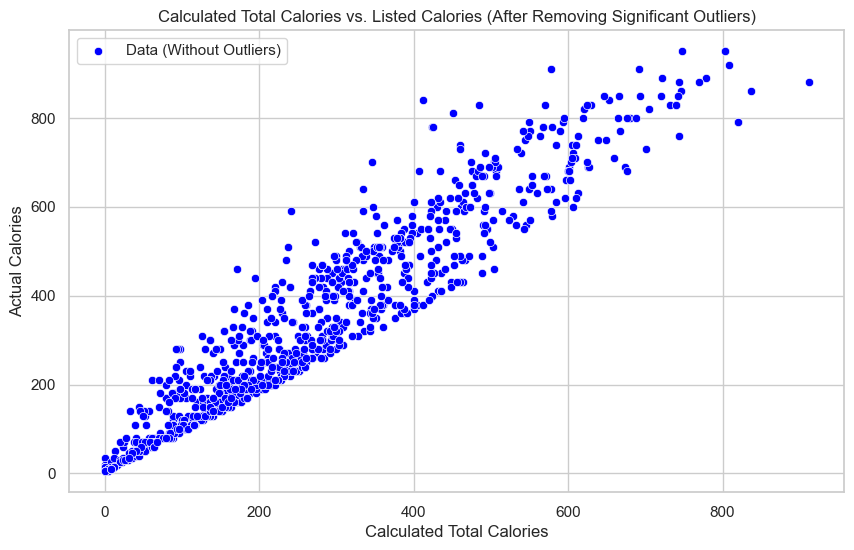

In [19]:
# Scatter plot to show the relationship between the calculated and actual calories (after removing outliers)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=cleaned_df['Calculated Total Calories'], y=cleaned_df['Calories'], color='blue', label='Data (Without Outliers)')

# Check
remaining_outliers = cleaned_df[cleaned_df['Percentage Difference'] > threshold]
sns.scatterplot(x=remaining_outliers['Calculated Total Calories'], y=remaining_outliers['Calories'], color='red', label='Remaining Outliers')

plt.title("Calculated Total Calories vs. Listed Calories (After Removing Significant Outliers)")
plt.xlabel("Calculated Total Calories")
plt.ylabel("Actual Calories")
plt.legend()
plt.show()


In [20]:
# Save the cleaned dataset to a new CSV file
cleaned_df.to_csv("C:/Users/asmit/OneDrive/Desktop/fast_food_nutrition/data/cleaned_nutrition_data_no_outliers.csv", index=False)


Calculating percentage of entries that are outliers / physically impossible

In [21]:
# Calculate the percentage of outliers in the dataset
total_entries = len(merged_df)
outlier_entries = len(significant_outliers)
outlier_percentage = (outlier_entries / total_entries) * 100

# Print the percentage of outliers
print(f"Percentage of entries that are significant outliers: {outlier_percentage:.2f}%")


Percentage of entries that are significant outliers: 1.86%


In [22]:

# Load data
df = pd.read_csv("C:/Users/asmit/OneDrive/Desktop/fast_food_nutrition/data/cleaned_nutrition_data_no_outliers.csv")

# Drop rows where either 'Calories' or 'Protein (g)' is NaN
df = df.dropna(subset=["Calories", "Protein (g)"])

# Recalculate protein per 100 calories
df["Protein per 100 Cal"] = (df["Protein (g)"] / df["Calories"]) * 100

# Check that the new column has been added
df.head()


,Item,Calories,Total Fat (g),Saturated Fat (g),Trans Fat (g),Cholesterol (mg),Sodium (mg),Total Carbohydrates (g),Dietary Fiber (g),Sugars (g),...,category,Protein per 100 Cal,Category,Size,Protein Calories,Fat Calories,Sugar Calories,Calculated Total Calories,Calorie Difference,Percentage Difference
0,4 Count Chick-Fil-A Chick-N-Minis,360.0,13.0,4.0,0.0,60.0,1060,41,2.0,8.0,...,Other,5.555556,['Chicken'],NaN,80,117.0,32.0,229.0,-131.0,-0.363889
1,4 Count Mini Yeast Rolls,240.0,8.0,2.5,0.0,20.0,450,36,2.0,7.0,...,Other,2.500000,['Other'],NaN,24,72.0,28.0,124.0,-116.0,-0.483333
2,10 Count Chick-Fil-A Chick-N-Minis,910.0,34.0,10.0,0.0,150.0,2640,103,6.0,19.0,...,Other,5.384615,"['Chicken', 'Combo']",NaN,196,306.0,76.0,578.0,-332.0,-0.364835
3,"Bacon, Egg & Cheese Biscuit",420.0,23.0,11.0,0.0,180.0,1220,38,2.0,4.0,...,Other,3.571429,['Breakfast'],NaN,60,207.0,16.0,283.0,-137.0,-0.326190
4,"Bacon, Egg & Cheese Muffin",300.0,13.0,6.0,0.0,180.0,780,28,1.0,2.0,...,Other,5.333333,['Breakfast'],NaN,64,117.0,8.0,189.0,-111.0,-0.370000


In [23]:
# Summary stats for protein per 100 calories
summary = df["Protein per 100 Cal"].describe()
print(summary)


count    1055.000000
mean        3.836501
std         3.876942
min         0.000000
25%         0.000000
50%         3.437500
75%         5.619518
max        21.666667
Name: Protein per 100 Cal, dtype: float64


In [24]:
# Average protein per 100 cal by chain
chain_protein_density = (
    df.groupby('Chain')['Protein per 100 Cal']
    .mean()
    .sort_values(ascending=False)
)

print("Average Protein per 100 Calories by Chain:")
print(chain_protein_density)


Average Protein per 100 Calories by Chain:
Chain
Subway         5.787842
Chick-Fil-A    4.644099
Mcdonald'S     2.744188
Kfc            2.465692
Burger King    2.103041
Name: Protein per 100 Cal, dtype: float64


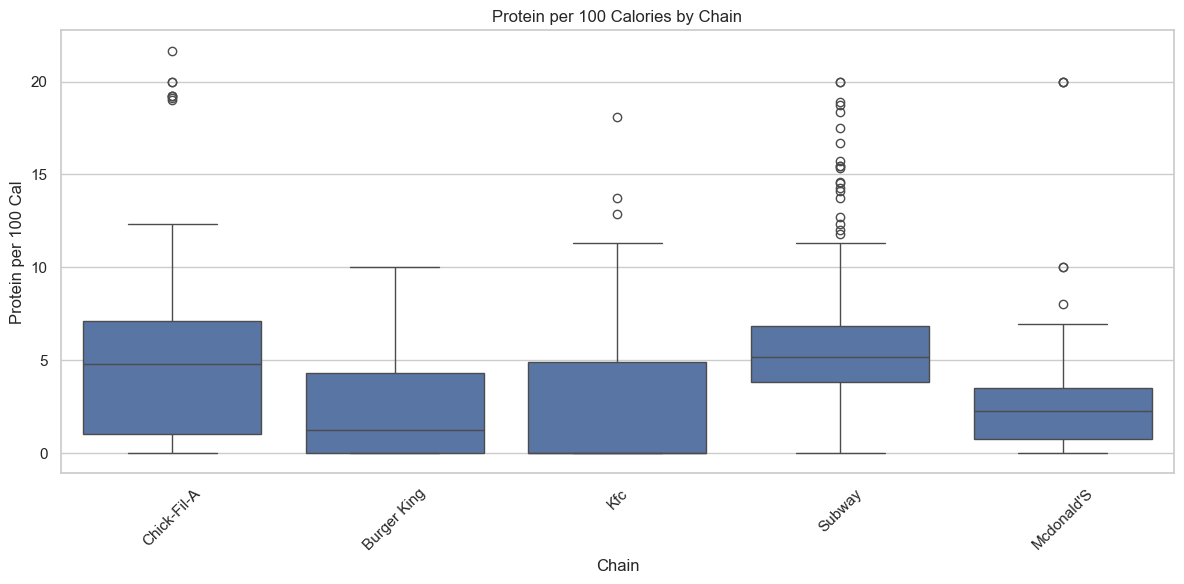

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Chain', y='Protein per 100 Cal')
plt.xticks(rotation=45)
plt.title("Protein per 100 Calories by Chain")
plt.tight_layout()
plt.savefig(r"C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\outputs\protein_per_100_cal_by_chain.png", dpi=300, bbox_inches='tight')
plt.show()


In [26]:
# Define rules for filtering
excluded_keywords = ['sauce', 'Tea', 'topping', 'cheese', 'parmesan', 'slice', 'ingredient']
excluded_categories = ['Other', 'Beverage']
min_calories = 40  # helps remove very low-calorie non-items

def is_valid_item(row):
    # Check if any excluded keyword is in the item name
    name_lower = row['Item'].lower()
    if any(keyword in name_lower for keyword in excluded_keywords):
        return False
    # Flatten category list
    cat_list = eval(row['Category']) if isinstance(row['Category'], str) else row['Category']
    if any(cat in excluded_categories for cat in cat_list):
        return False
    if row['Calories'] < min_calories:
        return False
    return True

# Apply filter
filtered_df = df[df.apply(is_valid_item, axis=1)]

# Get the new top 20 protein-dense items
top_protein_dense_clean = filtered_df.sort_values(by='Protein per 100 Cal', ascending=False).head(20)

# Preview
print("Filtered Top 20 Protein-Dense Items (per 100 Cal):")
print(top_protein_dense_clean[['Item', 'Chain', 'Category', 'Calories', 'Protein (g)', 'Protein per 100 Cal']])

# Save cleaned version
top_protein_dense_clean.to_csv("C:/Users/asmit/OneDrive/Desktop/fast_food_nutrition/data/top_protein_dense_items_cleaned.csv", index=False)


Filtered Top 20 Protein-Dense Items (per 100 Cal):
                                       Item        Chain  \
234                 Grilled Breakfast Filet  Chick-Fil-A   
835                         Grilled Chicken       Subway   
141            Kids 5 Count Grilled Nuggets  Chick-Fil-A   
56                  5 Count Grilled Nuggets  Chick-Fil-A   
58                  8 Count Grilled Nuggets  Chick-Fil-A   
77                          Grilled Nuggets  Chick-Fil-A   
62                 30 Count Grilled Nuggets  Chick-Fil-A   
235                           Grilled Filet  Chick-Fil-A   
60                 12 Count Grilled Nuggets  Chick-Fil-A   
836                Grilled Chicken, Buffalo       Subway   
509        Kentucky Grilled Chicken® Breast          Kfc   
763            Grilled Chicken Protein Bowl       Subway   
843                Rotisserie-Style Chicken       Subway   
768                 Roast Beef Protein Bowl       Subway   
766        Oven Roasted Turkey Protein Bowl      

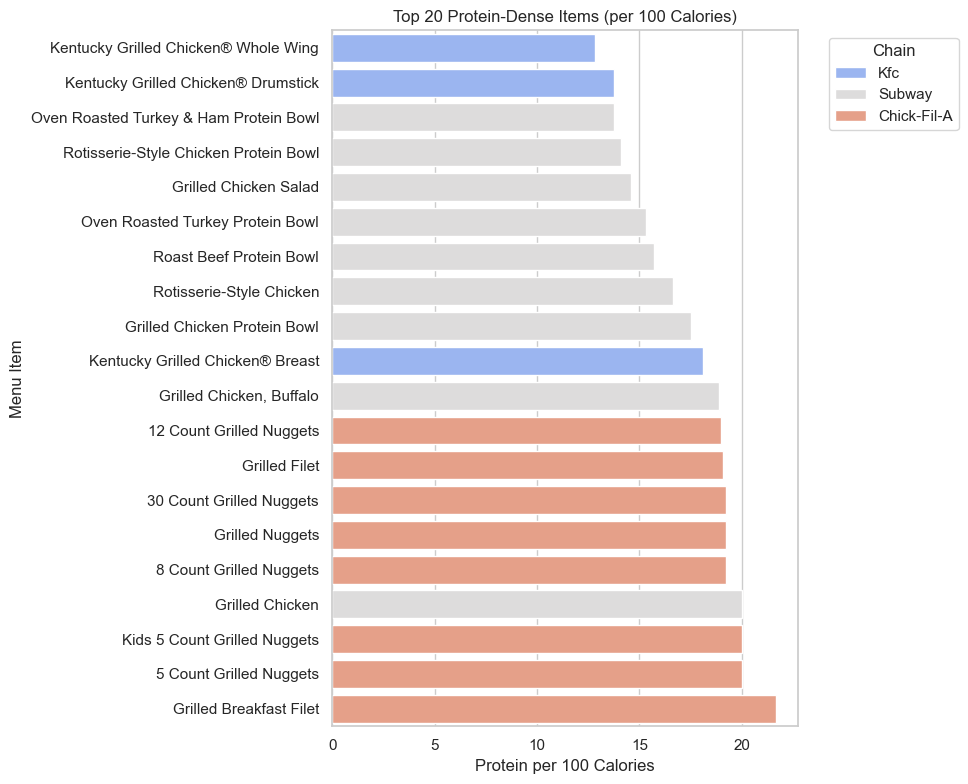

C:\Users\asmit\AppData\Local\Temp\ipykernel_21140\65852634.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Chain', y='Protein per 100 Cal', palette='Set2')


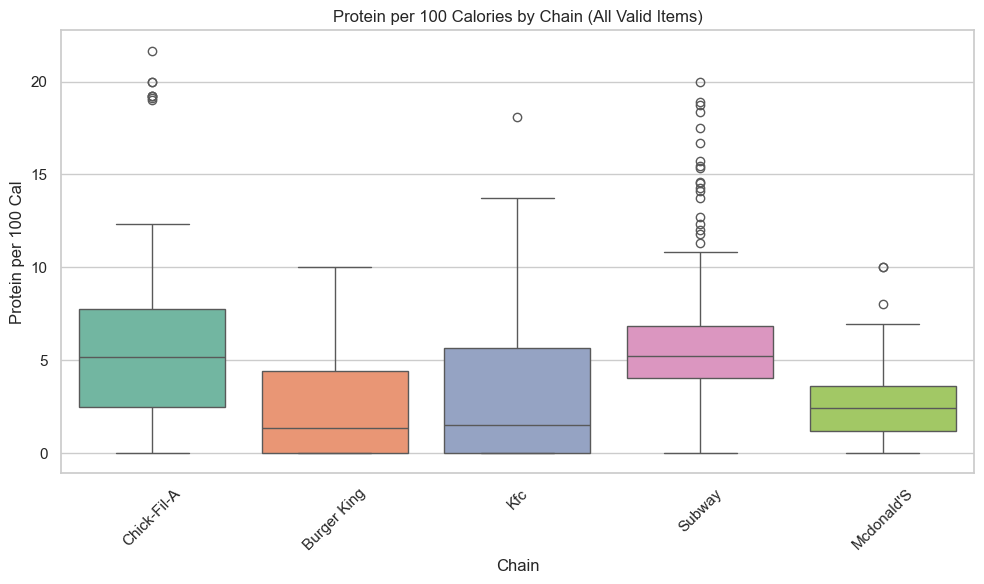


Average Protein per 100 Cal by Category:
 Category
['Chicken']             18.360980
['Chicken', 'Combo']    16.863636
['Combo']               14.932540
['Chicken', 'Salad']    14.615385
Name: Protein per 100 Cal, dtype: float64

 Unusual Low-Calorie, High-Protein Items:
                                  Item  Calories  Protein (g)  \
234           Grilled Breakfast Filet      60.0           13   
835                   Grilled Chicken      80.0           16   
141      Kids 5 Count Grilled Nuggets      80.0           16   
56            5 Count Grilled Nuggets      80.0           16   
58            8 Count Grilled Nuggets     130.0           25   
77                    Grilled Nuggets     130.0           25   
235                     Grilled Filet     110.0           21   
60           12 Count Grilled Nuggets     200.0           38   
836          Grilled Chicken, Buffalo      90.0           17   
509  Kentucky Grilled Chicken® Breast     210.0           38   

     Protein per 100 

In [38]:
# Protein per 100 Calories for Top 20
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_protein_dense_clean.sort_values('Protein per 100 Cal', ascending=True),
    x='Protein per 100 Cal',
    y='Item',
    hue='Chain',
    palette='coolwarm',
    dodge=False
)
plt.title("Top 20 Protein-Dense Items (per 100 Calories)")
plt.xlabel("Protein per 100 Calories")
plt.ylabel("Menu Item")
plt.legend(title='Chain', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(r"C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\outputs\top_20_protein_dense_items.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='Chain', y='Protein per 100 Cal', palette='Set2')
plt.title("Protein per 100 Calories by Chain (All Valid Items)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Average protein density by category
avg_density_by_category = top_protein_dense_clean.groupby('Category')['Protein per 100 Cal'].mean().sort_values(ascending=False)
print("\nAverage Protein per 100 Cal by Category:\n", avg_density_by_category)

# Spotlight on sauces/low-cal items
low_cal_high_protein = top_protein_dense_clean[(top_protein_dense_clean['Calories'] < 300) & (top_protein_dense_clean['Protein per 100 Cal'] > 18)]
print("\n Unusual Low-Calorie, High-Protein Items:\n", low_cal_high_protein[['Item', 'Calories', 'Protein (g)', 'Protein per 100 Cal']])

C:\Users\asmit\AppData\Local\Temp\ipykernel_21140\243033350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Fat-to-Protein Ratio'] = filtered_df['Total Fat (g)'] / filtered_df['Protein (g)']
C:\Users\asmit\AppData\Local\Temp\ipykernel_21140\243033350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
C:\Users\asmit\AppData\Local\Temp\ipykernel_21140\243033350.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.

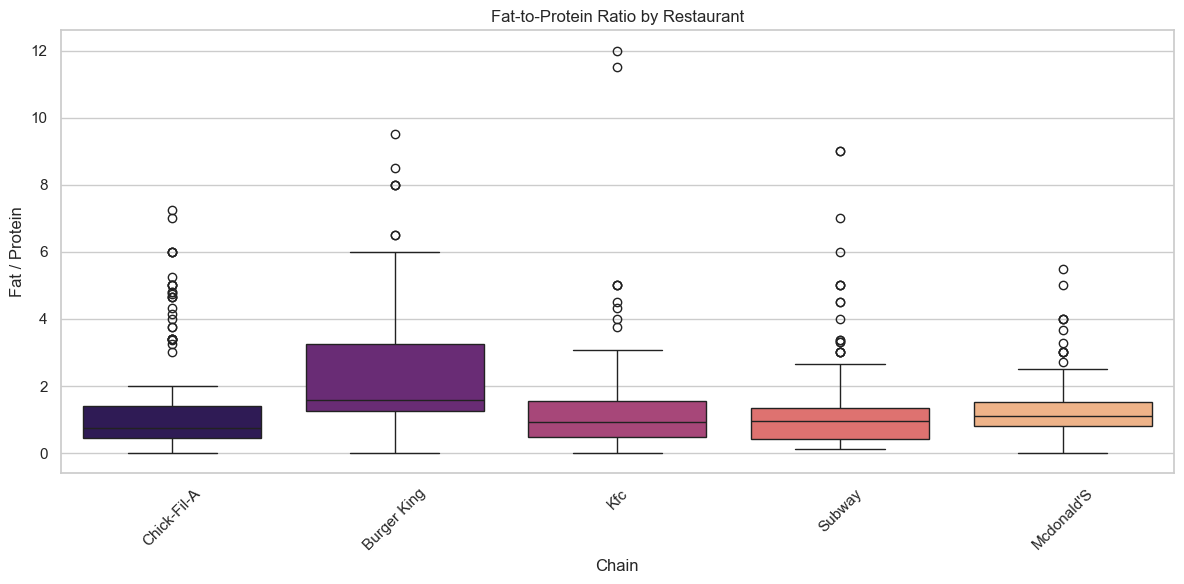

In [39]:
filtered_df['Fat-to-Protein Ratio'] = filtered_df['Total Fat (g)'] / filtered_df['Protein (g)']
filtered_df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)

plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_df, x='Chain', y='Fat-to-Protein Ratio', palette='magma')
plt.title('Fat-to-Protein Ratio by Restaurant')
plt.ylabel('Fat / Protein')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(r"C:\Users\asmit\OneDrive\Desktop\fast_food_nutrition\outputs\fat_to_protein_ratio_by_chain.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\asmit\AppData\Local\Temp\ipykernel_21140\2542166275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Category_str'] = filtered_df['Category'].astype(str)
C:\Users\asmit\AppData\Local\Temp\ipykernel_21140\2542166275.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sugar_df, x='Chain', y='Sugars (g)', palette='rocket')


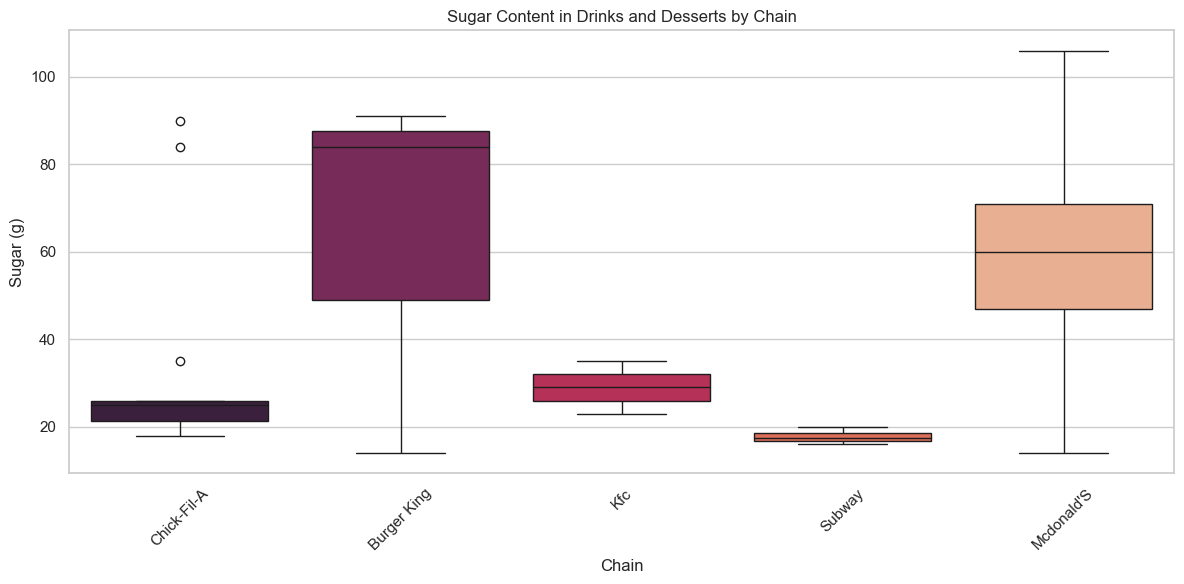

In [29]:
# Convert Category from list to string so we can search it
filtered_df['Category_str'] = filtered_df['Category'].astype(str)

# Filter for drinks and desserts
sugar_df = filtered_df[filtered_df['Category_str'].str.contains('Drink|Dessert', case=False, na=False)]

# Plot sugar content by chain
plt.figure(figsize=(12, 6))
sns.boxplot(data=sugar_df, x='Chain', y='Sugars (g)', palette='rocket')
plt.title('Sugar Content in Drinks and Desserts by Chain')
plt.ylabel('Sugar (g)')
plt.xlabel('Chain')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# List of beverages and sauces to exclude
exclude_items = [
    'Hot Tea', 'Lemonade', 'Iced Tea', 'Soda', 'Drink', 'Tea', 'Juice', 
    'Sauce', 'Dressing', 'Ketchup', 'Mustard', 'Buffalo Sauce', 'BBQ Sauce', 
    'Mayo', 'Parmesan'
]

# Filter out any rows containing these items (case-insensitive)
filtered_df = merged_df[~merged_df['Item'].str.contains('|'.join(exclude_items), case=False, na=False)]

# Remove duplicates and keep the most relevant data (max protein per 100 calories)
filtered_df_no_duplicates = filtered_df.groupby('Item').agg({
    'Chain': 'first',  # Take the first chain listed for each item
    'Calories': 'first',  # Take the first calorie value listed
    'Protein (g)': 'sum',  # Sum protein if there are multiple entries for the same item
    'Protein per 100 Cal': 'max'  # Keep the highest protein density for duplicates
}).reset_index()

# Sort items by protein density 
filtered_df_no_duplicates = filtered_df_no_duplicates.sort_values(by='Protein per 100 Cal', ascending=False)

# Prepare a list to store the top healthy items and a flag for Nugget items
top_healthy_items = []
excluded_nuggets = False  # This flag helps us skip extra "Nuggets" after the first one

# Loop through the sorted items to select the top 5, excluding repeated Nuggets
for index, row in filtered_df_no_duplicates.iterrows():
    item_name = row['Item']
    
    # If it's a "Nuggets" item and we've already included one skip it
    if 'nuggets' in item_name.lower():
        if excluded_nuggets:
            continue  # Skip this item
        excluded_nuggets = True  
    
    # Otherwise, add the item to the list
    top_healthy_items.append(row)

# Convert the list of top healthy items back to a DataFrame
top_healthy_df = pd.DataFrame(top_healthy_items)

# Get the top 5 items
top_healthy = top_healthy_df.head(5)

# Print the results
print("Top 5 Healthiest Items (Protein per 100 Cal):")
print(top_healthy[['Item', 'Chain', 'Calories', 'Protein (g)', 'Protein per 100 Cal']])


Top 5 Healthiest Items (Protein per 100 Cal):
                             Item        Chain  Calories  Protein (g)  \
413       Grilled Breakfast Filet  Chick-Fil-A      60.0           13   
541  Kids 5 Count Grilled Nuggets  Chick-Fil-A      80.0           16   
414               Grilled Chicken       Subway      80.0           16   
426                 Grilled Filet  Chick-Fil-A     110.0           21   
424      Grilled Chicken, Buffalo       Subway      90.0           17   

     Protein per 100 Cal  
413            21.666667  
541            20.000000  
414            20.000000  
426            19.090909  
424            18.888889  


In [32]:
# Define X and y from your DataFrame
X = df[['Calories', 'Sodium (mg)', 'Total Fat (g)', 'Total Carbohydrates (g)', 'Sugars (g)']]
y = df['Protein per 100 Cal']

# Combine X and y to drop rows with any NaNs or Infs
df_for_regression = pd.concat([X, y], axis=1)

# Remove rows with NaN or infinite values
df_for_regression = df_for_regression.replace([np.inf, -np.inf], np.nan).dropna()

# Reassign cleaned data
X_clean = df_for_regression[['Calories', 'Sodium (mg)', 'Total Fat (g)', 'Total Carbohydrates (g)', 'Sugars (g)']]
y_clean = df_for_regression['Protein per 100 Cal']

# Add constant to X
X_clean = sm.add_constant(X_clean)

# Fit the regression model
model = sm.OLS(y_clean, X_clean).fit()

# Print the summary
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     Protein per 100 Cal   R-squared:                       0.511
Model:                             OLS   Adj. R-squared:                  0.508
Method:                  Least Squares   F-statistic:                     218.9
Date:                 Wed, 23 Apr 2025   Prob (F-statistic):          5.30e-160
Time:                         18:59:44   Log-Likelihood:                -2549.1
No. Observations:                 1055   AIC:                             5110.
Df Residuals:                     1049   BIC:                             5140.
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

In [33]:
# Remove any rows with invalid protein density values 
valid_protein_df = filtered_df[np.isfinite(filtered_df['Protein per 100 Cal'])]

# Only keep chains that have more than one unique protein density value — 
chains_with_variation = [
    chain for chain, values in valid_protein_df.groupby('Chain')['Protein per 100 Cal']
    if values.dropna().nunique() > 1
]

# Keep only rows from those valid chains
anova_ready_df = valid_protein_df[valid_protein_df['Chain'].isin(chains_with_variation)]

# Organize the protein density values into separate groups by chain
protein_groups_by_chain = [
    anova_ready_df[anova_ready_df['Chain'] == chain]['Protein per 100 Cal']
    for chain in chains_with_variation
]

# Run the ANOVA test to see if there's a statistically significant difference 
anova_result = stats.f_oneway(*protein_groups_by_chain)

# Display the result
print(f'ANOVA Result: F-statistic = {anova_result.statistic:.2f}, p-value = {anova_result.pvalue:.4f}')

ANOVA Result: F-statistic = 51.35, p-value = 0.0000


In [34]:
# Create binary labels for "healthy" items based on protein density
filtered_df['Healthy'] = (filtered_df['Protein per 100 Cal'] > filtered_df['Protein per 100 Cal'].median()).astype(int)

# Calculate basic statistics for healthy vs unhealthy items
healthy_items = filtered_df[filtered_df['Healthy'] == 1]
unhealthy_items = filtered_df[filtered_df['Healthy'] == 0]

# Calculate mean protein, calories, and sodium for each category
healthy_stats = healthy_items[['Protein per 100 Cal', 'Calories', 'Sodium (mg)']].mean()
unhealthy_stats = unhealthy_items[['Protein per 100 Cal', 'Calories', 'Sodium (mg)']].mean()

# Count the number of healthy and unhealthy items
healthy_count = len(healthy_items)
unhealthy_count = len(unhealthy_items)

# Display results
print(f"### Healthy vs Unhealthy Items Based on Protein Density")
print("\n**Healthy Items (Protein per 100 Cal > median)**:")
print(f"- Average Protein per 100 Cal: {healthy_stats['Protein per 100 Cal']:.2f}g")
print(f"- Average Calories: {healthy_stats['Calories']:.2f} kcal")
print(f"- Average Sodium: {healthy_stats['Sodium (mg)']:.2f} mg")
print(f"- Total number of healthy items: {healthy_count}")

print("\n**Unhealthy Items (Protein per 100 Cal <= median)**:")
print(f"- Average Protein per 100 Cal: {unhealthy_stats['Protein per 100 Cal']:.2f}g")
print(f"- Average Calories: {unhealthy_stats['Calories']:.2f} kcal")
print(f"- Average Sodium: {unhealthy_stats['Sodium (mg)']:.2f} mg")
print(f"- Total number of unhealthy items: {unhealthy_count}")


### Healthy vs Unhealthy Items Based on Protein Density

**Healthy Items (Protein per 100 Cal > median)**:
- Average Protein per 100 Cal: 7.09g
- Average Calories: 382.51 kcal
- Average Sodium: 1029.63 mg
- Total number of healthy items: 443

**Unhealthy Items (Protein per 100 Cal <= median)**:
- Average Protein per 100 Cal: 1.50g
- Average Calories: 276.92 kcal
- Average Sodium: 343.32 mg
- Total number of unhealthy items: 496


C:\Users\asmit\AppData\Local\Temp\ipykernel_21140\2472747181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Healthy'] = (filtered_df['Protein per 100 Cal'] > filtered_df['Protein per 100 Cal'].median()).astype(int)
